In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from re import findall as fa
import sqlite3
import pymorphy2
import math
import importlib
import pickle


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats.stats import pearsonr as corr

from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import seaborn as sns

import matplotlib.pyplot as plt
from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='onedork')

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [4]:
text = """
Иногда я пишу о книгах, лубочек очень злят меня плов которые произвели на меня впечатление. Писать большие отзывы сейчас не хочется, поэтому в порядке перечисления.
"Атлант расправил плечи" - за внаивышшей мере последнее время понравилась больше всего наряду с Довлатовым (но насчет последнего сомнений и не было). Почему-то раньше я думал, что это что-то вроде "Финансиста" Драйзера. Так же, видимо, думают и люди, рисующие мемы "сын маминой подруги расправил плечи". А на самом деле книга об альтернативной вселенной, где в США наступил социализм. Очень рекомендую.
Что до "Финансиста" Драйзера, то т.д. он надолго отбил у меня желание читать этого автора. Не потому что мне не интересно читать про рынок - наоборот, про рынок интересно. Но всё остальное там скучно, особенно герои. Может быть, так и было задумано, но я это не люблю.
Дилогия об Остапе Бендере - сыночек начинаются обе книги весело, кончаются обе книги уныло. Не столько с точки зрения событий, сколько с точки зрения того, как трансформируется язык. Поэтому от них остается неприятное ощущение, хотя написаны они ярко, весело и интересно. Впрочем, не пойти на такую сделку вряд ли можно было в условиях, в которых работали авторы.
"Три мушкетера". Ну, не побоюсь если сыночком доченька сыночка оболочка опочка б я хотел бы этого я слова, такое. Занятно, но не более того - я сейчас даже с трудом вспомнил об этой книжке. Главный интерес книжка представляет с исторической точки зрения. В том числе и потому, что является убедительным доказательством, что во Франции в 17м веке был интернет и портативные телепорты - ну или по крайней мере бесстыдная сценарная магия.
Отто Кариус, "Тигры в грязи". орешек печьками котик солдатиков маленькую котеночек котенька необходимость тк изза тогочто обязана Язык Все всяк по видимому каждому каждый каждая этой можетбыть кажеться наверное наверно книги совершенно ужасен, может быть, потому что её писал солдат. Но прочитать очень стоит, потому что мало что может быть так ценно, как новая точка зрения на нечто хорошо знакомое!
"""

In [5]:
fa('\sбы?\s',text)

[' б ', ' бы ']

In [6]:
lib = {
    'allpos': ['PRED', 'None', 'PRTS', 'ADJF', 'INFN', 
         'PRTF', 'NOUN', 'ADVB', 'VERB', 'NPRO', 
         'NUMR', 'CONJ', 'ADJS', 'PRCL', 'PREP', 'COMP', 'INTJ'],
    'pos': ['ADJF', 'NOUN', 'ADVB', 'VERB', 'CONJ', 'PREP', 'INTJ', 'None'],
    'uncert' : ['наверное?', 'может[\s-]?быть', 'кажеть?ся', 
           'видимо', 'возможно', 'по[\s-]?видимому', 
           'вероятно', 'должно[\s-]?быть','пожалуй', 'как[\s-]?видно'],
    'cert' : ['очевидно','конечно','точно','совершенно',
         'не\s?сомненно','разумееть?ся', 
         'по[\s-]?любому','сто[\s-]?пудово?'],
    'quan' : ['вс[её]x?','всегда','ни-?когда', 'постоянно', 
         'ник(?:то|ого|ому|ем)', 
         'кажд(?:ый|ая|ой|ому?|ое|ого|ую|ые|ою|ыми?|ых)',
         'всяк(?:ий|ая|ое|ого|ую|ому?|ой|ою|ими?|их|ие)',
         'люб(?:ой|ая|ое|ого|ому?|ую|ой|ыми?|ых|ые)'],
    'imper' : ['долж(?:ен|на|ны|но)', 'обязан(?:а|ы|о|)', 
          'надо\W', 'нуж(?:но|ен|на|ны)', 
          'требуеть?ся', 'необходим(?:а|ы|о|)\W'],
    'racio' : ['по\s?этому', 'по\s?тому,?\s?что', 'следовательно', 
          'из[\s-]?за\s?того,?\s?что', 'из[\s-]?за\s?этого', 
          'по\s?причине', 'в\s?следстви[ие]', 'так\s?как', 'т\.?к\.?',
          'поскольк[оу]', 'чтобы'],
    'dimin' : ['\w+[ое]ньк(?:ая|ий|ое|ие|ую|ого|ому|ой|ими|а|о|у|е)', 
          '\w+очек\s', '\w+[ие]к(?:ами?|ов|у|а|е|и|)\s'],
    'extrem' : ['че?резвычайно', 'слишком', 'чере[cз]чур', 'ужасно',
           'безумно', 'крайне', 'предельно',
           'исключительно', 'невероятно', 'в\s?(?:наи|)вы[сш]шей (?:степени|мере)'],
    'like' : ['люблю', '[оa]б[оa]жаю','восхища[ею]т',
        'в\s?восторге', 'нрав[ия]ть?ся'],
    'dislike' : ['бес[ия]т', 'ненавижу', 'терпеть\s?не\s?могу', 
           'раздража[ею]т', 'зл[ия]т', 'выбешива[ею]т', ]
}

In [7]:
def ct(x, co=0, steep=0, ec50=0.5, level='max', adb=True):
    def carryover(x, l=0):
        co = []
        co.append((1-l)*x[0])
        for i in range(1,len(x)):
            co.append((1-l)*x[i] + l*co[i-1])
        return co

    def adbudg(x, steep, ec50, level):
        cap = max(x) if level == 'max' else level
        adb = []
        for i in x:
            adb.append(0 if i == 0 else cap/(1 + (i/(cap*ec50))**(-steep))) 
        return adb

    def logcurve(x, steep, ec50, level):
        cap = max(x) if level == 'max' else level*max(x)
        crv = []
        for i in x:
            crv.append(cap/(1+math.exp((-steep)*(i/cap-ec50))) - cap/(1+math.exp(steep*ec50)))
        return crv
      
    ct = x
    if steep > 0:
        ct = adbudg(x, steep, ec50, level) if adb else logcurve(x, steep, ec50, level)
    ct = carryover(ct, co) if co > 0 else ct
    return ct

def cleanse(s):
    rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
    return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))

def set_groups(x, dev=1, M=50, SD=10):
    if x > M+dev*SD:
        return 'high'
    elif x < M-dev*SD:
        return 'low'
    else:
        return 'average'
    
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def extract_features(text, morph=pymorphy2.MorphAnalyzer(), 
                 pos_types=lib['pos'], 
                 uncert=lib['uncert'],
                 cert=lib['cert'], 
                 quan=lib['quan'], 
                 imper=lib['imper'], 
                 racio=lib['racio'], 
                 dimin=lib['dimin'], 
                 extrem=lib['extrem'],
                 like=lib['like'],
                 dislike=lib['dislike']):
    
    from re import findall as fa
    #length in chars and words
    len_char = len(text)
    len_word = len(text.split())
    len_sent = len(fa('[^\.\!\?]+[\.\!\?]', text))
    len_sent = len_sent if len_sent else 1
    pun = fa('[\.+,!\?:-]',text)
    n_pun = len(pun)
    braсket_list = fa('[\(\)]',text)
      
    #POS & grammem
    def cleanse(s):
        rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
        return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))
    
    def parse_text(text, morph=morph):
        tokens = cleanse(text).split()
        return [morph.parse(t) for t in tokens]
    
    parsed_text = parse_text(text)
    pos_list = [str(p[0].tag.POS) for p in parsed_text]
    n_nouns = len([t for t in pos_list if t=='NOUN'])
    n_verbs = len([t for t in pos_list if t=='VERB'])
    n_ad = len([t for t in pos_list if t in ['ADJF','ADVB']])
    anim_list = [str(p[0].tag.animacy) for p in parsed_text]
    pers_list = [str(p[0].tag.person) for p in parsed_text]
    tns_list = [str(p[0].tag.tense) for p in parsed_text]
    asp_list = [str(p[0].tag.aspect) for p in parsed_text]
      
    r = lambda x: round(x, 4)
    d = lambda x, y: x / y if y else 0.0
    
    features = {
        #surface features
        'len_char': len_char, 
        'len_word': len_word,
        'len_sent': len_sent,
        'm_len_word': r(len_char / len_word),
        'm_len_sent': r(len_word / len_sent),
        #punctuation
        'p_pun': r(len(pun) / len_char),
        'p_dot': r(d(len([i for i in pun if i=='.']), len(pun))),
        'p_qm': r(d(len([i for i in pun if i=='?']), len(pun))),
        'p_excl': r(d(len([i for i in pun if i=='!']), len(pun))),
        'p_comma': r(d(len([i for i in pun if i==',']), len(pun))),
        'p_brkt': r(len(braсket_list) / len_char),
        'p_brkt_up': r(d(len([i for i in braсket_list if i==')']), len(braсket_list))),
        #POS form
        'pos_form': ' '.join(pos_list),
        'pos_richness': len(set(pos_list)),
        #grammem features
        'p_anim': r(d(len([t for t in anim_list if t=='anim']), n_nouns)),
        'p_1per': r(d(len([t for t in pers_list if t=='1per']), n_verbs)),
        'p_3per': r(d(len([t for t in pers_list if t=='3per']), n_verbs)),
        'p_past': r(d(len([t for t in tns_list if t=='past']), n_verbs)),
        'p_fut': r(d(len([t for t in tns_list if t=='futr']), n_verbs)),
        'p_pres': r(d(len([t for t in tns_list if t=='pres']), n_verbs)),
        'p_perf': r(d(len([t for t in asp_list if t=='perf']), n_verbs)),
        'p_conj': r(d(len(fa('\sбы?\s',text)), n_verbs)),
        #lexical features
        'p_uncert': r(len(fa('|'.join(uncert), text.lower())) / len_word),
        'p_cert': r(len(fa('|'.join(cert), text.lower())) / len_word),
        'p_quan': r(len(fa('|'.join(quan), text.lower())) / len_word),
        'p_imper': r(len(fa('|'.join(imper), text.lower())) / len_word),
        'p_racio': r(len(fa('|'.join(racio), text.lower())) / len_word),
        'p_dimin': r(len(fa('|'.join(dimin), text.lower())) / len_word),    
        'p_extrem': r(len(fa('|'.join(extrem), text.lower())) / len_word), 
        'p_like': r(len(fa('|'.join(like), text.lower())) / len_word),    
        'p_dislike': r(len(fa('|'.join(dislike), text.lower())) / len_word),  
    }
    
    for f in pos_types:
        features['p_'+f] = r(len([t for t in pos_list if t==f])/len(pos_list))
        
    return features

In [9]:
extrem = ['че?резвычайно','слишком','чере[cз]чур','ужасно','безумно','крайне',
         'исключительно','предельно','исключительно','невероятно',
          'в\s?(?:наи|)вы[сш]шей (?:степени|мере)']
like = ['люблю', '[оa]б[оa]жаю','восхища[ею]т',
        'в\s?восторге', 'нрав[ия]ть?ся']
dislike = ['бес[ия]т', 'ненавижу', 'терпеть\s?не\s?могу', 
           'раздража[ею]т', 'зл[ия]т', 'выбешива[ею]т', ]
fa('|'.join(dislike), text)

['злят']

In [10]:
%%time
extract_features(text, morph=pymorphy2.MorphAnalyzer())

Wall time: 161 ms


{'len_char': 2039,
 'len_sent': 25,
 'len_word': 320,
 'm_len_sent': 12.8,
 'm_len_word': 6.3719,
 'p_1per': 0.4375,
 'p_3per': 0.4375,
 'p_ADJF': 0.1028,
 'p_ADVB': 0.1277,
 'p_CONJ': 0.0966,
 'p_INTJ': 0.0,
 'p_NOUN': 0.2741,
 'p_None': 0.0218,
 'p_PREP': 0.0935,
 'p_VERB': 0.0997,
 'p_anim': 0.2955,
 'p_brkt': 0.001,
 'p_brkt_up': 0.5,
 'p_cert': 0.0031,
 'p_comma': 0.4754,
 'p_conj': 0.0625,
 'p_dimin': 0.0312,
 'p_dislike': 0.0031,
 'p_dot': 0.3934,
 'p_excl': 0.0164,
 'p_extrem': 0.0063,
 'p_fut': 0.0625,
 'p_imper': 0.0031,
 'p_like': 0.0031,
 'p_past': 0.5938,
 'p_perf': 0.5,
 'p_pres': 0.5312,
 'p_pun': 0.0299,
 'p_qm': 0.0,
 'p_quan': 0.0219,
 'p_racio': 0.025,
 'p_uncert': 0.0281,
 'pos_form': 'ADVB NPRO VERB PREP NOUN NOUN ADVB VERB NPRO NOUN ADJF VERB PREP NPRO NOUN INFN ADJF NOUN ADVB PRCL VERB ADVB PREP NOUN NOUN NOUN VERB NOUN None PREP PRTF NOUN ADJF NOUN VERB COMP ADVB ADVB PREP NOUN CONJ PREP ADJF NOUN CONJ PRCL VERB ADVB COMP NPRO VERB CONJ PRCL NPRO PRCL NOUN NOUN 

In [85]:
class TraitModel():
    def __init__(self, xname, traits, word_vectorizer, pos_vectorizer, 
                 library, test_size, morph, classifier, classifier_params={}, 
                 curves_params={'co':0, 'steep':0, 'ec50':0.5}):
        self.xname = xname
        self.traits = traits
        self.wv = word_vectorizer
        self.posv = pos_vectorizer
        self.lib = library
        self.test_size = test_size
        self.morph = morph
        self.models = {}
        self.quality = {'train':{}, 'test':{}}
        self.cl = classifier
        self.cl_params = classifier_params
        self.ct_params = curves_params
    
    def fit(self, data, mtype='n'):
        self.mtype = mtype       
        #extract features
        df_feat = pd.DataFrame.from_records(list(data[self.xname].apply(extract_features, 
                                                                        morph=self.morph)))
        df_feat.index = data.index
        data = pd.concat([data, df_feat], axis=1, join='inner')
        feat_names = list(extract_features('ы', morph=self.morph).keys())
        feat_names.remove('pos_form')
        #apply curve transformation
        for f in feat_names:
            data[f] = ct(data[f], **self.ct_params)     
        #clean before vectorization
        data[self.xname] = data[self.xname].apply(cleanse)
        #train-test split 
        train, test = train_test_split(data, test_size=self.test_size, random_state=42)
        #vectorize
        train_w_vec = self.wv.fit_transform(train.loc[:,'text']) #words tf:idf
        test_w_vec = self.wv.transform(test.loc[:,'text'])
        train_p_vec = self.posv.fit_transform(train.loc[:,'pos_form']) #pos tf:idf
        test_p_vec = self.posv.transform(test.loc[:,'pos_form'])
        X_train = np.hstack((train_w_vec.todense(), 
                             train_p_vec.todense(), 
                             train.loc[:,feat_names]))
        X_test = np.hstack((test_w_vec.todense(), 
                            test_p_vec.todense(), 
                            test.loc[:,feat_names]))
        
        self.fitted_features = self.wv.get_feature_names() \
                             + self.posv.get_feature_names() \
                             + feat_names 
        self.data = data
        self.train = train
        self.test = test
        self.X_train = X_train
        self.X_test = X_test
        self.feat_names = feat_names
        
        # build feature models
        def build_model(X_train, X_test, y_train, y_test, model):
            model.fit(X_train, y_train)
            return model
        
        for trait in trait_names:
            lm = self.cl(**self.cl_params)
            trait = trait+'_nom' if self.mtype == 'n' else trait          
            self.models[trait] = build_model(self.X_train, self.X_test, 
                                             self.train.loc[:,trait], self.test.loc[:,trait], 
                                             model=lm)      
    
    def summary(self, correlations=0.1, vec_tokens=15, coefs = 10,
                all_traits=True, clr=True, confusion=True):
        
        def title(name, m='=', l=50, up=True):
            n = name.upper() if up else name
            return '\n{}\n{}\n{}'.format(m*l, n, m*l)
        
        if correlations > 0:
            print(title('CORRELATIONS'))
            for trait in self.traits:
                print(title(trait, m='-', l=20, up=False))
                for feat in self.feat_names:
                    cor = corr(self.data.loc[:,trait], self.data.loc[:,feat])
                    if abs(cor[0]) > correlations:
                        print('{} | {} : r = {:.2}'.format(feat, trait, cor[0], cor[1]))
                        
        def vect_summary(vectorizer, name, show_tokens):
            print(title(name))
            print('\nIncluded tokens ({})'.format(len(vectorizer.get_feature_names())))
            print(np.array(vectorizer.get_feature_names())\
                  [np.random.randint(0, len(vectorizer.get_feature_names()), show_tokens)])
            print('\nExcluded tokens ({})'.format(len(vectorizer.stop_words_)))
            print(np.array(list(vectorizer.stop_words_))\
                  [np.random.randint(0, len(vectorizer.stop_words_), show_tokens)]) 
            
        if vec_tokens > 0:
            vect_summary(self.wv, 'words', vec_tokens)
            vect_summary(self.posv, 'pos tags', vec_tokens)            
        
        print(title('prediction quality'))
        if self.mtype == 'n' and all_traits:
            for trait in self.traits:
                trait = trait+'_nom'
                print(title(trait, m='-', l=20, up=False))
                model = self.models[trait]
                y_train = self.train.loc[:,trait]
                y_test = self.test.loc[:,trait]
                y_train_pred = model.predict(self.X_train)
                y_test_pred = model.predict(self.X_test)
                self.quality['train'][trait+'_acc'] = accuracy_score(y_train, y_train_pred)
                self.quality['test'][trait+'_acc'] = accuracy_score(y_test, y_test_pred)
                print('\nAccuracy on train: {:.2%}'.format(accuracy_score(y_train, y_train_pred)))
                if clr: print(classification_report(y_train, y_train_pred))
                print('Accuracy on test: {:.2%}'.format(accuracy_score(y_test, y_test_pred)))
                if clr: print(classification_report(y_test, y_test_pred))
                if confusion:
                    labels = y_train.unique()
                    sns.set_context("notebook")
                    plt.figure(figsize=(4,3))
                    sns.heatmap(data=confusion_matrix(y_test, y_test_pred, labels = labels), 
                                annot=True, fmt="d", cbar=False, 
                                xticklabels=labels, yticklabels=labels, cmap='viridis')
                    plt.title("Confusion matrix")
                    plt.xlabel('True')
                    plt.ylabel('Predicted')
                    plt.title("Confusion matrix for "+y_train.name, fontsize=12, fontweight='bold');
                    plt.show()
        
        if self.mtype == 'c' and all_traits:       
            for trait in self.traits:
                print(title(trait, m='-', l=20, up=False))
                model = self.models[trait]
                y_train = self.train.loc[:,trait]
                y_test = self.test.loc[:,trait]
                y_train_pred = model.predict(self.X_train)
                y_test_pred = model.predict(self.X_test)
                self.quality['train'][trait+'_R2'] = r2_score(y_train, y_train_pred)
                self.quality['test'][trait+'_R2'] = r2_score(y_test, y_test_pred)
                print('MAPE on train: {:.2f}%'.format(mape(y_train, y_train_pred)))
                print('R2 on train: {:.3f}'.format(r2_score(y_train, y_train_pred)))
                print('\nMAPE on test: {:.2f}%'.format(mape(y_test, y_test_pred)))
                print('R2 on train: {:.3f}'.format(r2_score(y_test, y_test_pred)))
        
        print(title('Mean quality', m='-', l=20, up=False))
        metric = 'R2' if self.mtype == 'c' else 'Accuracy'
        for k,v in self.quality.items():
            print('Mean {} on {}: {:.3}'.format(metric, k, sum(v.values())/len(v.values())))
            
        if coefs and str(type(list(self.models.values())[0])) == "<class 'sklearn.linear_model.logistic.LogisticRegression'>":
            print(title('coefs'))
            for trait in self.traits: 
                trait = trait + '_nom' if self.mtype == 'n' else trait
                print(title(trait, m='-', l=20, up=False))
                for i, level in enumerate(self.models[trait].classes_):
                    print('\n'+level.upper())
                    features = self.fitted_features
                    coefs_ = self.models[trait].coef_.tolist()[i]
                    coefdf = pd.DataFrame({'Feature' : features, 
                                           'Coefficient' : coefs_})
                    coefdf = coefdf.sort_values(['Coefficient', 'Feature'], ascending=[0, 1])
                    print(coefdf.head(coefs))
    
    def export(self, path='models/', fname='model'):
        with open(path+fname+'.pickle', 'wb') as f:
            pickle.dump(self, f)
            
    def predict(self, text):
        feats = extract_features(text, morph=self.morph)
        featvec = np.array([feats[f] for f in self.feat_names])
        X = np.hstack((self.wv.transform([text]).todense(), 
                       self.posv.transform([feats['pos_form']]).todense(), 
                       np.matrix(featvec)))
        predictions = {k:v.predict(X) for k, v in self.models.items()}
        return predictions

In [86]:
#get text data from db
conn = sqlite3.connect('ud.db')
c = conn.cursor()
query = 'SELECT DISTINCT owner_id, text FROM posts WHERE text IS NOT NULL AND text != "";'
texts = pd.read_sql(query, conn)
lens = np.array([len(str(t)) for t in texts.text])
trsh_up, trsh_lo = 9000, 700
lens = np.array([len(str(t)) for t in texts.text])
texts = texts[(lens < trsh_up) & (lens > trsh_lo)]
texts.shape

(2164, 2)

In [87]:
#load psychological data and transform traits
names_HEX = ['HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']
names_TWf = ['TWf1_eX', 'TWf2_A', 'TWf3_C', 'TWf4_E', 'TWf5_O', 'TWf6_H']
names_TWc = ['TWc1_eX', 'TWc2_A', 'TWc3_C', 'TWc4_N', 'TWc5_O', 'TWc6_H']
names_M = ['M'+i[3:] for i in names_HEX]
cols = ['id', 'sex'] + names_HEX + names_TWf + names_TWc

traits = pd.read_csv('data/survey_data.csv', sep=';', decimal=',', usecols=cols)

for i, t in enumerate(names_M):
    traits[t] = (traits[names_HEX[i]] + traits[names_TWf[i]] + traits[names_TWc[i]])/3

trait_names = names_HEX + names_TWf + names_TWc + names_M

print('trait high average low')
for trait in trait_names:
    scale = trait + '_nom'
    traits[scale] = traits[trait].apply(set_groups, dev=0.5)
    print(trait, [traits[scale].value_counts()[i] for i in range(3)])
    
trait_names = names_M

trait high average low
HEX1_eX [53, 51, 48]
HEX2_A [58, 51, 43]
HEX3_C [53, 52, 47]
HEX4_E [57, 48, 47]
HEX5_O [56, 50, 46]
HEX6_H [54, 50, 48]
TWf1_eX [57, 50, 45]
TWf2_A [55, 51, 46]
TWf3_C [62, 47, 43]
TWf4_E [53, 50, 49]
TWf5_O [57, 49, 46]
TWf6_H [53, 51, 48]
TWc1_eX [59, 49, 44]
TWc2_A [53, 52, 47]
TWc3_C [54, 52, 46]
TWc4_N [58, 49, 45]
TWc5_O [74, 40, 38]
TWc6_H [68, 44, 40]
M1_eX [61, 46, 45]
M2_A [59, 50, 43]
M3_C [64, 47, 41]
M4_E [69, 43, 40]
M5_O [65, 45, 42]
M6_H [66, 45, 41]


In [88]:
#join data
data_ = pd.merge(texts, traits, how='left', left_on='owner_id', right_on='id')
data_.shape

(2223, 52)

In [89]:
trm_logreg = TraitModel(xname = 'text',
                 traits = trait_names,
                 word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.7, 
                     max_features = 10000),
                 pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 50, 
                     max_df = 0.5, 
                     max_features = 5000),
                 library = lib,
                 test_size = 0.12,
                 morph = pymorphy2.MorphAnalyzer(),
                 classifier = LogisticRegression,
                 classifier_params = {'max_iter':155, 
                                      'multi_class':'multinomial',
                                      'solver':'newton-cg'},
                 curves_params = {'steep':1.5, 'ec50':0.5, 'level':'max', 'adb':False}
                )

In [90]:
%%time
trm_logreg.fit(data_, mtype='n')

Wall time: 3min 37s


In [92]:
text = """
Иногда я пишу о книгах, которые произвели на меня впечатление. Писать большие отзывы сейчас не хочется, поэтому в порядке перечисления.
"Атлант расправил плечи" - за последнее время понравилась больше всего наряду с Довлатовым (но насчет последнего сомнений и не было). Почему-то раньше я думал, что это что-то вроде "Финансиста" Драйзера. Так же, видимо, думают и люди, рисующие мемы "сын маминой подруги расправил плечи". А на самом деле книга об альтернативной вселенной, где в США наступил социализм. Очень рекомендую.
Что до "Финансиста" Драйзера, то он надолго отбил у меня желание читать этого автора. Не потому что мне не интересно читать про рынок - наоборот, про рынок интересно. Но всё остальное там скучно, особенно герои. Может быть, так и было задумано, но я это не люблю.
Дилогия об Остапе Бендере - начинаются обе книги весело, кончаются обе книги уныло. Не столько с точки зрения событий, сколько с точки зрения того, как трансформируется язык. Поэтому от них остается неприятное ощущение, хотя написаны они ярко, весело и интересно. Впрочем, не пойти на такую сделку вряд ли можно было в условиях, в которых работали авторы.
"Три мушкетера". Ну, не побоюсь этого слова, такое. Занятно, но не более того - я сейчас даже с трудом вспомнил об этой книжке. Главный интерес книжка представляет с исторической точки зрения. В том числе и потому, что является убедительным доказательством, что во Франции в 17м веке был интернет и портативные телепорты - ну или по крайней мере бесстыдная сценарная магия.
Отто Кариус, "Тигры в грязи". Язык этой книги совершенно ужасен, может быть, потому что её писал солдат. Но прочитать очень стоит, потому что мало что может быть так ценно, как новая точка зрения на нечто хорошо знакомое.
"""

In [95]:
trm_logreg.predict(text)

{'M1_eX_nom': array(['average'], dtype=object),
 'M2_A_nom': array(['average'], dtype=object),
 'M3_C_nom': array(['high'], dtype=object),
 'M4_E_nom': array(['average'], dtype=object),
 'M5_O_nom': array(['high'], dtype=object),
 'M6_H_nom': array(['high'], dtype=object)}


CORRELATIONS

--------------------
M1_eX
--------------------
m_len_sent | M1_eX : r = -0.1
p_brkt_up | M1_eX : r = -0.18
p_1per | M1_eX : r = 0.1
p_quan | M1_eX : r = 0.14
p_racio | M1_eX : r = -0.1
p_VERB | M1_eX : r = 0.12
p_None | M1_eX : r = -0.13

--------------------
M2_A
--------------------
m_len_sent | M2_A : r = -0.17
pos_richness | M2_A : r = 0.14
p_fut | M2_A : r = 0.14
p_pres | M2_A : r = 0.1
p_perf | M2_A : r = 0.13
p_ADJF | M2_A : r = 0.11
p_NOUN | M2_A : r = 0.2
p_ADVB | M2_A : r = -0.16
p_VERB | M2_A : r = 0.15
p_None | M2_A : r = -0.21

--------------------
M3_C
--------------------
p_anim | M3_C : r = -0.11
p_past | M3_C : r = -0.19
p_fut | M3_C : r = 0.12
p_pres | M3_C : r = 0.12
p_ADVB | M3_C : r = -0.13

--------------------
M4_E
--------------------
p_brkt | M4_E : r = 0.13
p_brkt_up | M4_E : r = 0.23
p_anim | M4_E : r = -0.14
p_1per | M4_E : r = 0.18
p_3per | M4_E : r = -0.17
p_NOUN | M4_E : r = -0.13
p_ADVB | M4_E : r = 0.15

--------------------
M5_O
-------

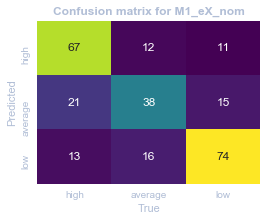


--------------------
M2_A_nom
--------------------

Accuracy on train: 94.07%
             precision    recall  f1-score   support

    average       0.92      0.98      0.95       856
       high       0.96      0.88      0.92       532
        low       0.95      0.94      0.95       568

avg / total       0.94      0.94      0.94      1956

Accuracy on test: 68.54%
             precision    recall  f1-score   support

    average       0.70      0.78      0.73       130
       high       0.59      0.53      0.56        60
        low       0.74      0.65      0.69        77

avg / total       0.68      0.69      0.68       267



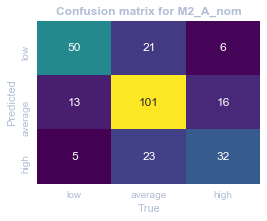


--------------------
M3_C_nom
--------------------

Accuracy on train: 93.81%
             precision    recall  f1-score   support

    average       0.93      0.92      0.93       546
       high       0.92      0.98      0.95       867
        low       0.97      0.89      0.93       543

avg / total       0.94      0.94      0.94      1956

Accuracy on test: 70.04%
             precision    recall  f1-score   support

    average       0.68      0.44      0.54        81
       high       0.72      0.90      0.80       122
        low       0.67      0.64      0.66        64

avg / total       0.70      0.70      0.69       267



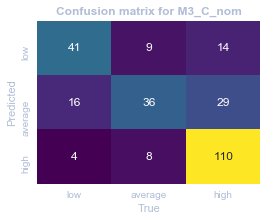


--------------------
M4_E_nom
--------------------

Accuracy on train: 92.89%
             precision    recall  f1-score   support

    average       0.96      0.84      0.90       442
       high       0.91      0.98      0.94       980
        low       0.95      0.92      0.93       534

avg / total       0.93      0.93      0.93      1956

Accuracy on test: 67.79%
             precision    recall  f1-score   support

    average       0.50      0.23      0.31        61
       high       0.72      0.89      0.80       144
        low       0.63      0.63      0.63        62

avg / total       0.65      0.68      0.65       267



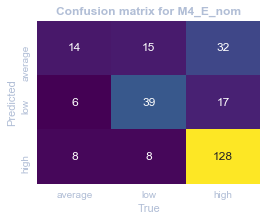


--------------------
M5_O_nom
--------------------

Accuracy on train: 89.01%
             precision    recall  f1-score   support

    average       0.95      0.63      0.76       361
       high       0.86      0.97      0.91       971
        low       0.93      0.92      0.92       624

avg / total       0.90      0.89      0.89      1956

Accuracy on test: 64.42%
             precision    recall  f1-score   support

    average       0.52      0.24      0.33        50
       high       0.62      0.78      0.69       124
        low       0.72      0.68      0.70        93

avg / total       0.64      0.64      0.63       267



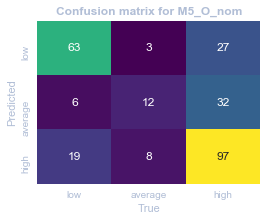


--------------------
M6_H_nom
--------------------

Accuracy on train: 90.03%
             precision    recall  f1-score   support

    average       0.88      0.99      0.93      1239
       high       0.98      0.69      0.81       291
        low       0.96      0.77      0.85       426

avg / total       0.91      0.90      0.90      1956

Accuracy on test: 69.29%
             precision    recall  f1-score   support

    average       0.70      0.97      0.81       168
       high       0.44      0.08      0.14        48
        low       0.75      0.35      0.48        51

avg / total       0.66      0.69      0.63       267



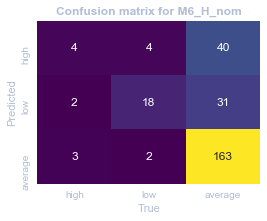


--------------------
Mean quality
--------------------
Mean Accuracy on train: 0.919
Mean Accuracy on test: 0.679

COEFS

--------------------
M1_eX_nom
--------------------

AVERAGE
      Coefficient                 Feature
4995     1.150707                  p_anim
1848     0.920544               цитаты из
698      0.907968         из прочитанного
1849     0.907968  цитаты из прочитанного
1396     0.868713            прочитанного
1210     0.808382                      он

HIGH
      Coefficient Feature
2002     1.510019       •
142      1.076075     бог
920      0.980954     мне
4988     0.964647   p_dot
170      0.962725    будь
870      0.959135  любовь

LOW
      Coefficient    Feature
4993     1.385700  p_brkt_up
1766     1.366536         ты
1377     1.178374        про
334      1.160906        все
820      0.998074    которые
137      0.959912     бизнес

--------------------
M2_A_nom
--------------------

AVERAGE
      Coefficient                 Feature
1766     1.409490      

In [96]:
trm_logreg.summary(correlations = 0.1, vec_tokens=12, coefs=6,
                   all_traits=True, clr=True, confusion=True)

In [97]:
%%time
trm_logreg.export(fname='model_logreg')

Wall time: 2.53 s


In [98]:
trm_rfr = TraitModel(xname = 'text',
                 traits = trait_names,
                 word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.7, 
                     max_features = 10000),
                 pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 50, 
                     max_df = 0.5, 
                     max_features = 5000),
                 library = lib,
                 test_size = 0.12,
                 morph = pymorphy2.MorphAnalyzer(),
                 classifier = RandomForestRegressor,
                 classifier_params = {'n_estimators':200, 
                                      'max_features':'log2', 
                                      'min_samples_leaf':5, 
                                      'oob_score': True,},
                 curves_params = {'steep':1.5, 'ec50':0.5, 'level':'max', 'adb':False}
                )

In [631]:
%%time
trm_rfr.fit(data_, mtype='c')

Wall time: 1min 21s


In [632]:
trm_rfr.summary(correlations = 0, vec_tokens=0)


PREDICTION QUALITY

--------------------
M1_eX
--------------------
MAPE on train: 14.33%
R2 on train: 0.520

MAPE on test: 17.00%
R2 on train: 0.241

--------------------
M2_A
--------------------
MAPE on train: 13.91%
R2 on train: 0.550

MAPE on test: 17.96%
R2 on train: 0.265

--------------------
M3_C
--------------------
MAPE on train: 13.78%
R2 on train: 0.529

MAPE on test: 18.41%
R2 on train: 0.226

--------------------
M4_E
--------------------
MAPE on train: 12.13%
R2 on train: 0.543

MAPE on test: 15.93%
R2 on train: 0.221

--------------------
M5_O
--------------------
MAPE on train: 14.31%
R2 on train: 0.514

MAPE on test: 18.11%
R2 on train: 0.153

--------------------
M6_H
--------------------
MAPE on train: 7.58%
R2 on train: 0.463

MAPE on test: 9.99%
R2 on train: 0.122

--------------------
Mean quality
--------------------
Mean R2 on train: 0.52
Mean R2 on test: 0.205


## NN Models

In [678]:
n_features = X_train.shape[1]
batch_size = 32

nb_filter = 250
filter_length = 3
nb_epoch = 15

In [679]:
y_tr = train.loc[:,'M2_A_nom']
y_te = test.loc[:,'M2_A_nom']
labels = y_tr.unique()

le = LabelEncoder()
le.fit(labels)
y_train = np_utils.to_categorical(le.transform(y_tr), 3)
y_test = np_utils.to_categorical(le.transform(y_te), 3)
y_true = le.transform(y_te)
print(y_train)

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 ..., 
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


In [680]:
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation = 'relu'))
model.add(Dropout(0.05))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  
          validation_split=0.07, verbose=2)

Train on 1380 samples, validate on 104 samples
Epoch 1/15
2s - loss: 4.9874 - acc: 0.3884 - val_loss: 2.2232 - val_acc: 0.5096
Epoch 2/15
1s - loss: 2.3499 - acc: 0.4268 - val_loss: 1.2325 - val_acc: 0.3750
Epoch 3/15
1s - loss: 2.0213 - acc: 0.4348 - val_loss: 1.7198 - val_acc: 0.4519
Epoch 4/15
1s - loss: 1.7561 - acc: 0.4703 - val_loss: 1.4289 - val_acc: 0.5288
Epoch 5/15
1s - loss: 1.4299 - acc: 0.5275 - val_loss: 0.9219 - val_acc: 0.6058
Epoch 6/15
1s - loss: 1.3428 - acc: 0.5696 - val_loss: 0.8617 - val_acc: 0.6346
Epoch 7/15
1s - loss: 0.9775 - acc: 0.6565 - val_loss: 1.1743 - val_acc: 0.5769
Epoch 8/15
1s - loss: 0.9949 - acc: 0.6638 - val_loss: 0.8624 - val_acc: 0.6635
Epoch 9/15
1s - loss: 0.7907 - acc: 0.6906 - val_loss: 0.9681 - val_acc: 0.5769
Epoch 10/15
1s - loss: 0.7017 - acc: 0.7543 - val_loss: 0.9216 - val_acc: 0.6154
Epoch 11/15
1s - loss: 0.7077 - acc: 0.7623 - val_loss: 0.8442 - val_acc: 0.6635
Epoch 12/15
1s - loss: 0.5617 - acc: 0.8283 - val_loss: 0.8523 - val_ac

In [681]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               559232    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 387       
Total params: 559,619
Trainable params: 559,619
Non-trainable params: 0
_________________________________________________________________


In [682]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))

 32/203 [===>..........................] - ETA: 1s             precision    recall  f1-score   support

          0       0.80      0.69      0.74        89
          1       0.66      0.70      0.68        50
          2       0.70      0.81      0.75        64

avg / total       0.74      0.73      0.73       203



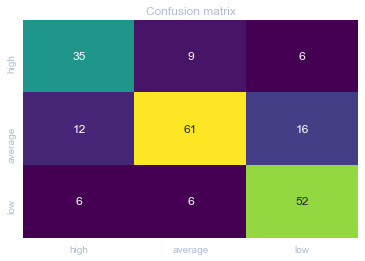

In [683]:
y_true_ = le.inverse_transform(y_true)
y_pred_ = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true_, y_pred_, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()